At this point we are ready to generate some data for model training.

In [163]:
%load_ext autoreload
%autoreload 2

import cv2
import uuid
import chess
import glob
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from cam_chess import capture, detect_checkerboard, adjust_perspective, chop, capture_pipeline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


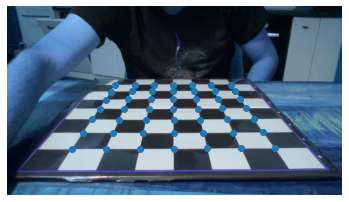

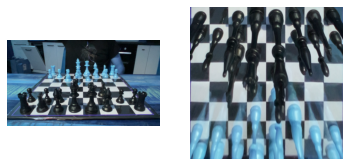

In [160]:
empty = np.load('img/empty_board.npy')
filled = np.load('img/filled_board.npy')

corners = detect_checkerboard(empty)
fig = adjust_perspective(filled, corners)
fields = chop(fig)

Our helper will receive chopped images and two lists (filled and empty) and will save images to deticated folders.

In [140]:
for handle in ['png', 'jpg', 'jpeg']:
    print(handle)
    print('before', fields['a1'][0][0])
    im = Image.fromarray(fields['a1'])
    print('after', np.array(im)[0][0])
    file_name = f'img/test.{handle}'
    im.save(file_name)
    print('cv2', cv2.imread(file_name)[0][0])
    print('PIL', np.array(Image.open(file_name))[0][0])

png
before [ 71  94 135]
after [ 71  94 135]
cv2 [135  94  71]
PIL [ 71  94 135]
jpg
before [ 71  94 135]
after [ 71  94 135]
cv2 [141  94  73]
PIL [ 73  94 141]
jpeg
before [ 71  94 135]
after [ 71  94 135]
cv2 [141  94  73]
PIL [ 73  94 141]


Since other readers can mess up data we will use PNG with PIL.

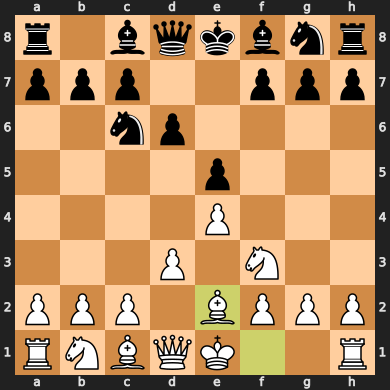

In [141]:
board = chess.Board()
for m in ['e4', 'e5', 'Nf3', 'Nc6', 'd3', 'd6', 'Be2']:
    board.push_san(m)
board

In [153]:
# !rm data/filled/*.png
# !rm data/empty/*.png

In [154]:
def save_train_data(fields, filled={}):
    for k, v in filled.items():
        handle = 'filled' if v else 'empty'
        Image.fromarray(fields[k]).save(f'data/{handle}/{k}_{uuid.uuid4().hex}.png')
        
def is_filled(board):
    filled_idx = board.piece_map().keys()
    return {chess.square_name(i): i in filled_idx for i in range(64)}

save_train_data(fields, is_filled(board))

# Let's make some more data!

Note, that each capture will produce 32 filled and 32 empty squares, thus producing a nice batch. Let's repeat each of the 9 variations 5 times for given board postion and let's reposition board can change lightning conditions couple times.

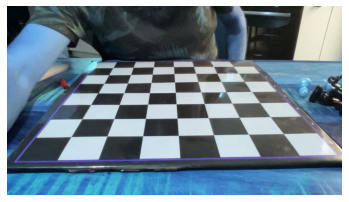

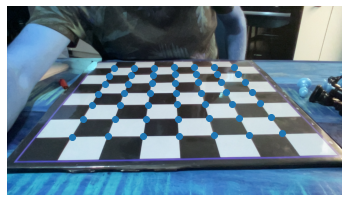

In [205]:
empty = capture()
corners = detect_checkerboard(empty)

In [206]:
all_fields = [f'{col}{row}' for row in range(1, 9) for col in 'abcdefgh']

## 1. Starting position (black/white and mixed) - 1, 2, 7, 8

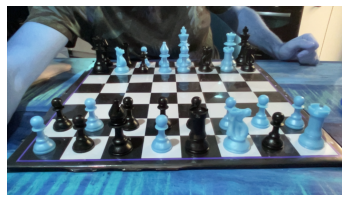

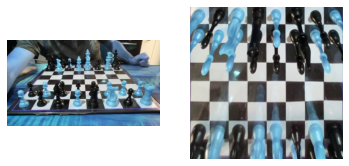

In [200]:
fields = {f'{col}{row}': row in [1, 2, 7, 8] for row in range(1, 9) for col in 'abcdefgh'}

save_train_data(capture_pipeline(corners), fields)

## 2. All on black squares - A1, ..., H8

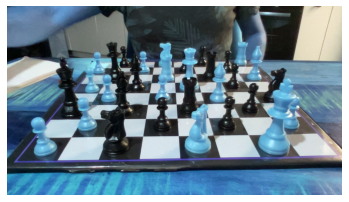

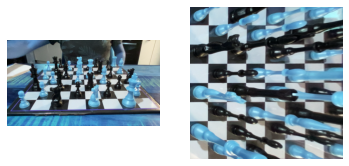

In [209]:
target =   [f'{col}{row}' for row in [1, 3, 5, 7] for col in 'aceg'] \
         + [f'{col}{row}' for row in [2, 4, 6, 8] for col in 'bdfh']
fields = {f: f in target for f in all_fields}

save_train_data(capture_pipeline(corners), fields)

## 3. All on white squares - B1, ..., G8

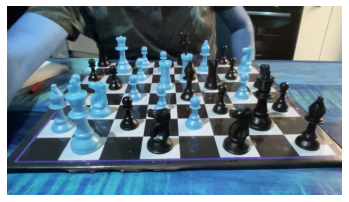

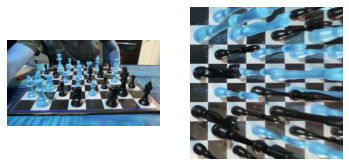

In [214]:
fields = {f: f not in target for f in all_fields}

save_train_data(capture_pipeline(corners), fields)

## 4. All in the center rows (horizontal) - 3, 4, 5, 6

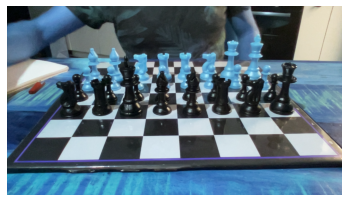

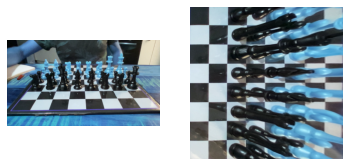

In [219]:
fields = {f'{col}{row}': row in [3, 4, 5, 6] for row in range(1, 9) for col in 'abcdefgh'}

save_train_data(capture_pipeline(corners), fields)

## 5. All in the left and right columns - A, B, G, H

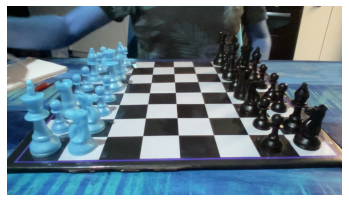

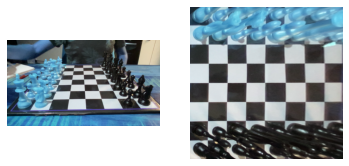

In [224]:
fields = {f'{col}{row}': col in 'abgh' for row in range(1, 9) for col in 'abcdefgh'}

save_train_data(capture_pipeline(corners), fields)

## 6. All in the middle rows (vertical) - C, D, E, F

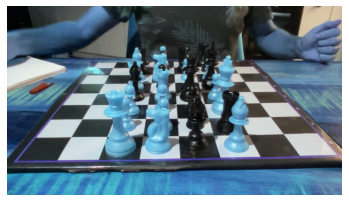

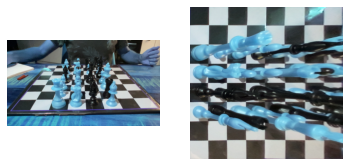

In [229]:
fields = {f'{col}{row}': col in 'cdef' for row in range(1, 9) for col in 'abcdefgh'}

save_train_data(capture_pipeline(corners), fields)

## 7. 1, 8 and 4, 5

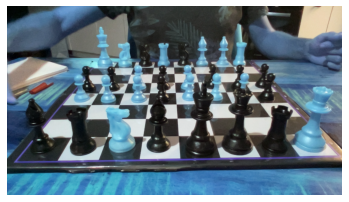

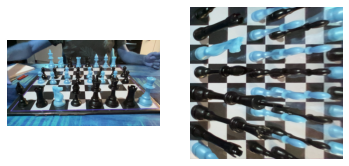

In [234]:
fields = {f'{col}{row}': row in [1, 8, 4, 5] for row in range(1, 9) for col in 'abcdefgh'}

save_train_data(capture_pipeline(corners), fields)

## 8. 1, 3, 5, 7

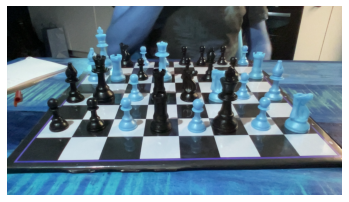

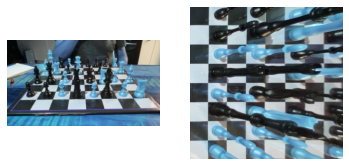

In [239]:
fields = {f'{col}{row}': row in [1, 3, 5, 7] for row in range(1, 9) for col in 'abcdefgh'}

save_train_data(capture_pipeline(corners), fields)

## 9. 2, 4, 6, 8

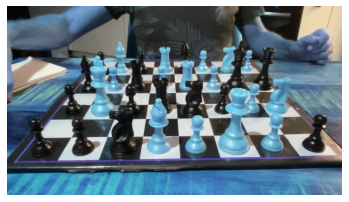

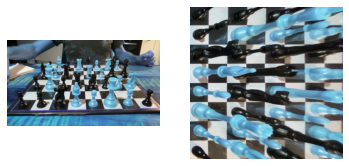

In [244]:
fields = {f'{col}{row}': row in [2, 4, 6, 8] for row in range(1, 9) for col in 'abcdefgh'}

save_train_data(capture_pipeline(corners), fields)

Now we are ready to jump into training.